# Import lib

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import random
random.seed(123)

## Getting the Score information for each Team from `output.csv`

In [30]:
# This file is contains the score of differnt teams
# `output.csv` does not contain team information It only contains the Team and its score information
output = pd.read_csv('output.csv')


In [31]:
# Convert all the entities to lower case
output['name'] = output['name'].apply(lambda x: x.lower())

# remove all punctuations and spaces, now concatenate the string
output['name'] = output['name'].str.replace(r'\W+', '').astype('str')

#unnecessary column
output.drop(columns=['score2'],inplace = True)

#based on the value of the columns divide into different classes.
#output['isEff'] = np.where(output.score1 > 40, 'Yes' , 'No')
output['isEff'] = np.where(output.score1 > 40, np.where(output.score1 > 70, 'Yes' , 'Mod'), 'No')

output.team_id = output.team_id.astype(str)

In [32]:
# Read Data 
# Data wrt to each member of the team
# need to be later grouped wrt teamName
data = pd.read_csv('Data.csv')

## Creating the Map of `teamName:Score`

In [33]:
# Create dictionaries
# Inorder to map the scores with the team Name
# The output.csv file contains the teamName and score Data
# Hence we need to map the scores for the different members of the team in the other data

nameMap = dict(zip(output.name,output.isEff))
idMap = dict(zip(output.team_id,output.isEff))
idToNameMap = dict(zip(output.team_id,output.name))

'''
# Adding the 'Temperament' Attribute
#data['Temperament'] = np.where(data.SI == 'Sensation',np.where(data.JP == 'Judgement','Gaurdian','Artisans'), np.where(data.TF == 'Feeling','Idealists','Rationals'))
'''

In [34]:
# Create a new column isEff
# using the dictionary maps created earlier 
 
def isEff(data):
    data['isEff'] = data['teamName'].map(nameMap)
    data['teamName'] = np.where(data['teamName'].str.contains(pat = '^[0-9].*'),data['teamName'].map(idToNameMap), data['teamName'] )
    data['isEff'] = np.where(pd.isnull(data.isEff) ,data['teamName'].map(nameMap),data.isEff)
    data['isEff'] = np.where(pd.isnull(data.isEff) ,data['teamName'].map(idMap),data.isEff)
    #print(data[['teamName','isEff']])
    return data

# Preprocessing for the teamName attribute to conver to lowercase and remove all spaces and punctuation 
def teamNameProcessing(data):
    data['teamName'] = data['teamName'].astype('str').apply(lambda x: x.lower())
    data['teamName'] = data['teamName'].str.replace(r'\W+','').astype('str')
    

# Converting to yes or no Attributes
def convertToYesNo(data,attr,val):
    data[attr] = np.where(data[attr] > val, 'Yes', 'No')

def percentage(x,val1,val2):
    c1 = 0
    c2 = 0
    for a in x:    
        if a == val1:
            c1=c1+1
        elif a == val2:
            c2=c2+1
            
    ratio = round(c1/(c1+c2),2)*100
    return ratio

def convertToTeamData(data,newAttr,oldAttr,val1,val2):
    data[newAttr] = data[oldAttr].str.split(',').apply(lambda x:sorted(x))
    data[newAttr] =  data[newAttr].apply(percentage, args = (val1,val2))
    return data


data = isEff(data)

data = data.sort_values(by = 'isEff')
data.to_csv('temp.csv',index = False)

# Preprocessing the Data Attributes

In [262]:
teamNameProcessing(data)

# Create a new Attribute Impact to see if a person is motivated to continue woring with the team
from statistics import mode
data['Impact'] = np.where(data.workedEarlier == 'No' , np.where(data.workAgain == 'Yes', 'Positive' , 'Negative'), np.where(data.workAgain == 'Yes', 'Neutral' , 'Negative'))


# Get all the Numerical data together
numerical = data.groupby('teamName').mean().reset_index()
numerical['equality'] =numerical[['equalContribution','cooperation']].mean(axis = 1)
numerical['SocialOrder'] =numerical[['equalContribution','appreciation','cooperation','freedom']].mean(axis = 1)
#convertToYesNo(numerical,'Difficulty',4)
convertToYesNo(numerical,'equalContribution',4)
convertToYesNo(numerical,'appreciation',4)
convertToYesNo(numerical,'cooperation',4)
convertToYesNo(numerical,'freedom',4)
convertToYesNo(numerical,'SocialOrder',4)

# Get all the Categorical data together
# each row represents a team
# the combination of the various responses of the members of the team for each categorical column
# is of the format: 
#[opinin1, opinion2, opinion3, opinion4] for a 4 membered team
#[opinin1, opinion2, opinion3] for a 3 membered team
categorical = data.groupby('teamName').agg(','.join).reset_index()


# setting the opinion to the mode of the attribute
categorical['Impact'] = categorical['Impact'].str.split(',')
categorical['Impact'] = categorical['Impact'].apply(lambda x: max(set(x), key = x.count))

# To obtain the size of the team
categorical['size'] = categorical['Gender'].str.split(',').str.len()
categorical = isEff(categorical)


# Convert all the attributes to percentages
categorical = convertToTeamData(categorical,'femalePercent','Gender','Female','Male')    
categorical = convertToTeamData(categorical,'IntrovertPercent','EI','Introvert','Extrovert')  
categorical = convertToTeamData(categorical,'IntuitionPercent','SI','Intuition','Sensation')
categorical = convertToTeamData(categorical,'ThinkingPercent','TF','Thinking','Feeling')
categorical = convertToTeamData(categorical,'JudgementPercent','JP','Judgement','Perception')  
categorical = convertToTeamData(categorical,'workedEarlierPercent','workedEarlier','Yes','No')  
categorical = convertToTeamData(categorical,'workAgainPercent','workAgain','Yes','No') 

# Drop unnecessary attributes
categorical.drop(['Gender', 'Personality', 'EI', 'SI', 'TF', 'JP',
       'workedEarlier','workAgain','Temperament'],axis = 1,inplace = True)

def splitToThree(data,attr,val1,val2,cat):
    data[attr] = np.where(data[attr] <= val1, cat[0],  np.where(data[attr] <= val2, cat[1], cat[2]))

# Convert the percentage to categories
splitToThree(categorical,'femalePercent',33,50,['FPLow','FPLow','FPHigh'])
splitToThree(categorical,'IntrovertPercent',33,50,['IELow','IELow','IEHigh'])
splitToThree(categorical,'IntuitionPercent',33,50,['INLow','INLow','INHigh'])
splitToThree(categorical,'ThinkingPercent',33,50,['TFLow','TFLow','TFHigh'])
splitToThree(categorical,'JudgementPercent',33,50,['JPLow','JPLow','JPHigh'])
splitToThree(categorical,'workedEarlierPercent',33,50,['WELow','WELow','WEHigh'])
splitToThree(categorical,'workAgainPercent',33,50,['WALow','WALow','WAHigh'])



In [300]:
teams = pd.merge(numerical,categorical, on = 'teamName')
#teams.drop(['Difficulty','teamName','workedEarlierPercent','workAgainPercent','Improvement','equalContribution','appreciation','cooperation','freedom'],axis = 1,inplace = True)
teams.drop(['Difficulty','teamName','workedEarlierPercent','workAgainPercent','Improvement'],axis = 1,inplace = True)
teams.sort_values(by = 'isEff')
teams.to_csv('FinalData.csv',index = False)
teams.columns

Index(['equalContribution', 'appreciation', 'cooperation', 'freedom',
       'equality', 'SocialOrder', 'Impact', 'size', 'isEff', 'femalePercent',
       'IntrovertPercent', 'IntuitionPercent', 'ThinkingPercent',
       'JudgementPercent'],
      dtype='object')

# Import all the models for Building a classifier

In [301]:
# Imports
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest,chi2,f_classif,mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# For plotting the decision Tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image  
import pydotplus


In [302]:
# Label Encoding for the entire Data 
# Both the dependent and the predictors variable

le = preprocessing.LabelEncoder()
teams = teams.apply(le.fit_transform)
class_name = {1:'Effective',0:'Not Effective',2:'Moderate'}

In [303]:
np.random.seed(3)
def prepare_data(teams,i):
    # Separating the predictors and the dependent variable

    y = teams.isEff
    X = teams.drop('isEff',axis=1)

    # Store the names of the selected columns
    feature_names = X.columns
    
    '''
    # Feature selection
    sel_chi2 = SelectKBest(score_func = mutual_info_classif, k=i)    
    sel_chi2.fit_transform(X, y)
    col_num = sel_chi2.get_support(indices = True)

    # Retaining only the selected K columns
    X = X.iloc[:,col_num]

    '''
    
    
    # After the feature selection, split the data into train and test
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.20, random_state = 1)

    params = {
                'train_X': train_X,
                'test_X': test_X,
                'train_y': train_y,
                'test_y': test_y,
                'feature_names' : feature_names
                 
             }
    return params


def model_building(params,depth):
    
    train_X = params['train_X']
    train_y = params['train_y']
    test_X = params['test_X']
    test_y = params['test_y']
    
    # Apply Decision Tree Model and predict on the test set

    dt = DecisionTreeClassifier(criterion='gini', random_state = 1, max_depth=depth, min_samples_split = 10)
    dt.fit(train_X,train_y)
    pred = dt.predict(test_X) 

    # Compute the accuracy of the model
    acc = accuracy_score(test_y, pred)
    
    params['accuracy'] = acc
    params['dt'] = dt
    
    return params



def find_best_k_features(teams):
    acc = []
    k = []
    for i in range(2,10):
        params = prepare_data(teams,i)
        k.append(i)
        params = model_building(params,3)
        acc.append(params['accuracy'])
        
    plt.plot(k,acc, label = 'accuracy')
    

    plt.xlabel('k')
    plt.ylabel('accuracy')
    plt.legend()

#find_best_k_features(teams)


def findBestDepth(teams):

    params = prepare_data(teams,4)# No of features 
    

    train_X = params['train_X']
    train_y = params['train_y']
    test_X = params['test_X']
    test_y = params['test_y']
    #print(teams.apply(pd.Series.value_counts))
    max_depth = []
    acc_gini = []
    acc_entropy = []
    for i in range(1,10):
        dtree = DecisionTreeClassifier(criterion='gini',random_state = 1,max_depth=i,min_samples_split = 10)
        dtree.fit(train_X, train_y)
        pred = dtree.predict(test_X)
        acc_gini.append(accuracy_score(test_y, pred))
        ####

        dtree = DecisionTreeClassifier(criterion= 'entropy',random_state = 1, max_depth=i,min_samples_split = 10)
        dtree.fit(train_X, train_y)
        pred = dtree.predict(test_X)
        acc_entropy.append(accuracy_score(test_y, pred))
        ####
        max_depth.append(i)
        d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
                          'acc_entropy':pd.Series(acc_entropy),
                          'max_depth':pd.Series(max_depth)})
    # visualizing changes in parameters
    plt.plot('max_depth','acc_gini',data = d, label = 'gini')
    plt.plot('max_depth','acc_entropy', data= d, label='entropy')

    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.legend()

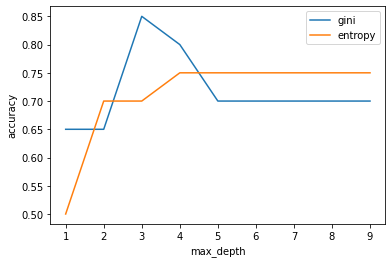

In [304]:
findBestDepth(teams)

In [305]:
params = prepare_data(teams,5)
params = model_building(params,3)
feature_names = params['feature_names']
dt = params['dt']

print(params['accuracy'])

0.85


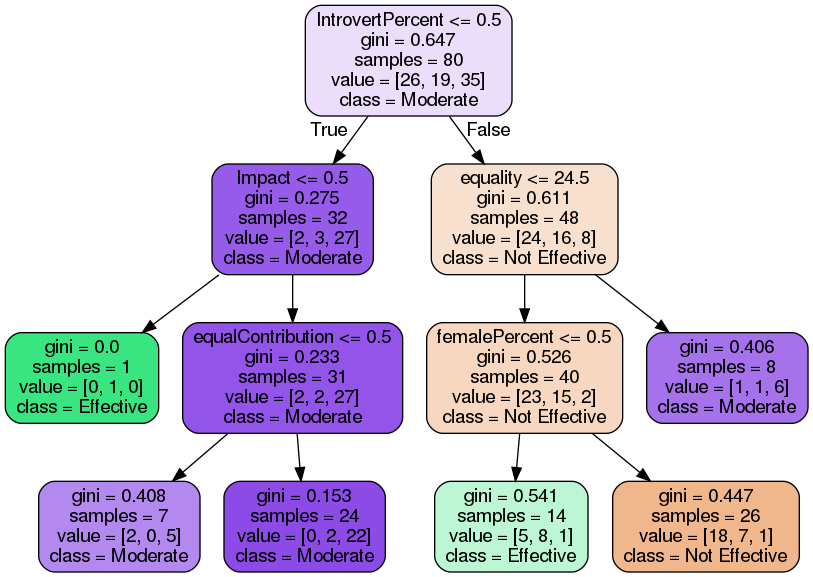

In [306]:
# create a string input output object
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                filled=True,
                rounded=True,
                feature_names=feature_names,
                class_names=class_name)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree.png')
Image(graph.create_png())


In [307]:
train_X = params['train_X']
train_y = params['train_y']
test_X = params['test_X']
test_y = params['test_y']
feature_names = params['feature_names']

from sklearn.linear_model import LogisticRegression
m = LogisticRegression(
    multi_class = 'multinomial',
    penalty='l2',
    C=1.0,
    solver = 'saga')
m.fit(train_X, train_y)
pred = m.predict(test_X)
m.predict_proba(test_X)
m.score(test_X,test_y)

/home/nimisha/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.75

In [296]:
from xgboost import XGBClassifier

m = XGBClassifier(
    max_depth=4,
    gamma=2,
    eta=0.8,
    reg_alpha=0.5,
    reg_lambda=0.5
)
m.fit(train_X, train_y)
pred = m.predict(test_X)
m.predict_proba(test_X)
m.score(test_X,test_y)

0.7

In [297]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='gini',max_depth=2)
bag = BaggingClassifier(tree, n_estimators=500, 
                        random_state=1)
bag.fit(train_X,train_y)
pred = bag.predict(test_X)

bag.score(test_X,test_y)

0.7

In [298]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(fit_prior=True)
clf.fit(train_X, train_y)
pred = clf.predict(test_X)
print(clf.score(test_X,test_y))

0.75


In [299]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
m = GradientBoostingClassifier(learning_rate = 0.1,
                              )
m.fit(train_X,train_y)
pred = m.predict(test_X)
print(m.score(test_X,test_y))


0.75
